In [721]:
import os
# os.environ['DEVICE_ID'] = '6'
import csv
import numpy as np

import mindspore as ms
from mindspore import nn
from mindspore import context
from mindspore import dataset
from mindspore.train.callback import LossMonitor
from mindspore.common.api import ms_function
from mindspore.ops import operations as P

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

In [722]:
with open('iris.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
data=data[:-1]

In [723]:
label_map = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2,
}

X = np.array([[float(x) for x in s[:-1]] for s in data], np.float32)
Y=[]
for s in data:
    yy=[0,0,0]
    idx=label_map[s[-1]]
    yy[idx]=1
    Y.append(yy)
Y = np.array(Y, np.float32)

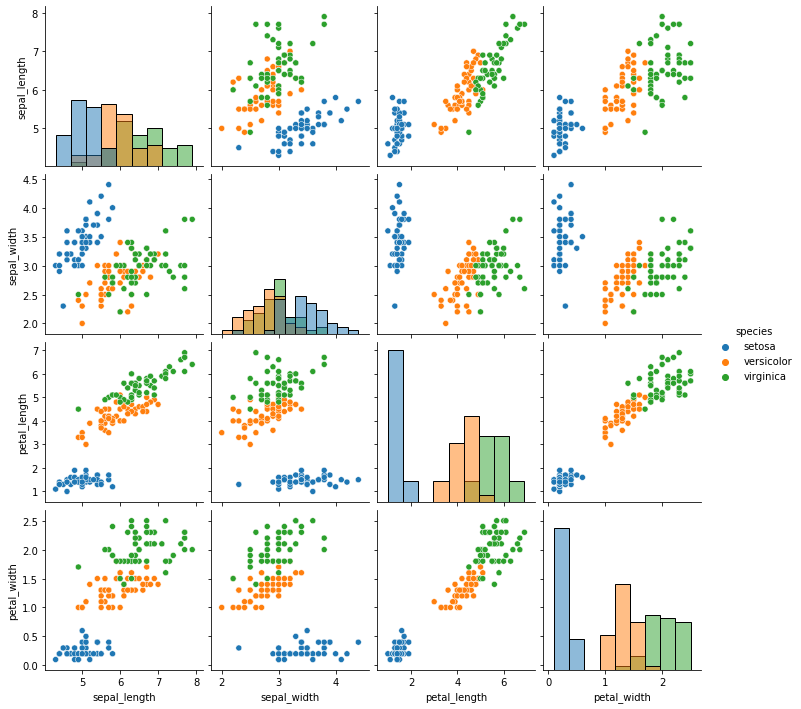

In [735]:
#!pip install seaborn
import seaborn as sns
from matplotlib import pyplot as plt
data=sns.load_dataset("iris")  
sns.pairplot(data=data,diag_kind='hist', hue= 'species')
plt.show()

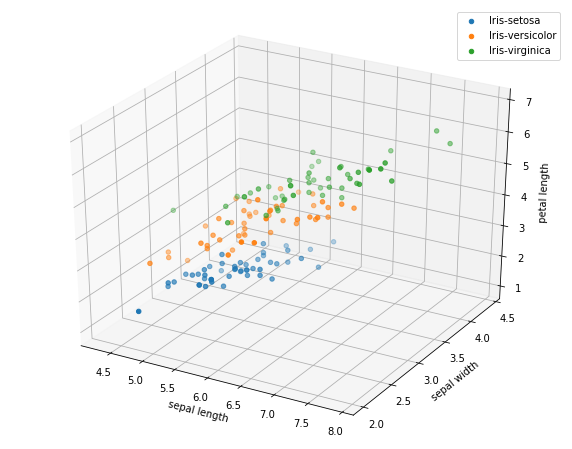

In [734]:
#选取其前三个特征绘制三维散点图
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:50, 0], X[:50, 1], X[:50,2],label='Iris-setosa')
ax.scatter(X[50:100, 0], X[50:100, 1],X[50:100, 2], label='Iris-versicolor')
ax.scatter(X[100:, 0], X[100:, 1],X[100:, 2], label='Iris-virginica')
ax.set_xlabel('sepal length')
ax.set_ylabel('sepal width')
ax.set_zlabel('petal length')
plt.legend()
plt.show()

In [726]:
train_idx = np.random.choice(150, 120, replace=False)
test_idx = np.array(list(set(range(150)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

In [727]:
XY_train = list(zip(X_train, Y_train))
ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y'])
# ds_train.set_dataset_size(80)
ds_train = ds_train.shuffle(buffer_size=120).batch(32, drop_remainder=True)
# print(XY_train)

In [728]:
# 自定义Loss
class Loss(nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()
        self.softmax_cross_entropy_with_logits = P.SoftmaxCrossEntropyWithLogits()
        self.reduce_mean = P.ReduceMean(keep_dims=False)
    def construct(self, x, y):
        loss,_ = self.softmax_cross_entropy_with_logits(x, y)
        return self.reduce_mean(loss, -1)

net = nn.Dense(4, 3)
loss = Loss()
opt = nn.optim.SGD(net.trainable_params(), learning_rate=0.1)

In [729]:
model = ms.train.Model(net, loss, opt)
model.train(50, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], dataset_sink_mode=False)

epoch: 1 step: 3, loss is 1.2734603
epoch: 2 step: 3, loss is 0.9077221
epoch: 3 step: 3, loss is 1.315928
epoch: 4 step: 3, loss is 0.756524
epoch: 5 step: 3, loss is 0.97375274
epoch: 6 step: 3, loss is 0.58471596
epoch: 7 step: 3, loss is 0.66181064
epoch: 8 step: 3, loss is 0.8866919
epoch: 9 step: 3, loss is 0.49420908
epoch: 10 step: 3, loss is 0.7917814
epoch: 11 step: 3, loss is 0.47891605
epoch: 12 step: 3, loss is 0.55566394
epoch: 13 step: 3, loss is 0.6759416
epoch: 14 step: 3, loss is 1.0194025
epoch: 15 step: 3, loss is 0.4584303
epoch: 16 step: 3, loss is 0.45261398
epoch: 17 step: 3, loss is 0.43764317
epoch: 18 step: 3, loss is 0.45686406
epoch: 19 step: 3, loss is 0.49368694
epoch: 20 step: 3, loss is 0.6667623
epoch: 21 step: 3, loss is 0.4788884
epoch: 22 step: 3, loss is 0.416564
epoch: 23 step: 3, loss is 0.5480127
epoch: 24 step: 3, loss is 0.48614573
epoch: 25 step: 3, loss is 0.5396619
epoch: 26 step: 3, loss is 0.41994107
epoch: 27 step: 3, loss is 0.36659306


In [730]:
x = model.predict(ms.Tensor(X_test)).asnumpy()
x=np.exp(x)
x_max=x.max(axis=1)
x_max=np.expand_dims(x_max, axis=1)
pred=np.floor(x/np.concatenate((x_max,x_max,x_max),axis=1))
# print(x/np.concatenate((x_max,x_max,x_max),axis=1))
# print(Y_test)
correct = np.equal(pred, Y_test)
acc = np.mean(correct)
print('Test accuracy is', acc)

Test accuracy is 1.0
